# えじさんって人の一部解法
- https://github.com/amaotone/atmacup-5
- Savitzky-Golayフィルターで3つの波形を生成
    - http://vp-happy-rikei-life.com/archives/9254949.html
    - https://datachemeng.com/wp-content/uploads/preprocessspectratimeseriesdata.pdf
- それらを(bs, 4, 512)としてConv NNに入れる(bs, 1, 512が普通？)
- 並列の畳み込み層(入力を複数の畳み込み層に通し、それらを１次元の形でconcat) -> 全結合層で最終的に1つ(結合したかどうか)の確率を出力
- 全結合層に入れる直前に、lgbなどでも使っていた特徴量などもconcatさせている

# おまけ(wavenet)
- 音声波形の生成モデル
- Causal Convolutions: 自己回帰モデル、過去の入力をもとに次の出力を出して、それを新たな入力としていく感じ？
- Dilated Causal Convolution: 畳み込むノードを離す。離すことで広いフィルターを使うことができる
- 僕らのモデルもdilated=2にしたり、カーネルサイズ上げるともっとよかったかも??
- この記事わかりやすい
    - https://qiita.com/MasaEguchi/items/cd5f7e9735a120f27e2a
- ここにコードがある(3rdの人はこれ使っていた)
    - https://www.kaggle.com/wimwim/wavenet-lstm
- [直感 Deep Learning](https://www.amazon.co.jp/Deep-Learning-%E2%80%95Python%C3%97Keras%E3%81%A7%E3%82%A2%E3%82%A4%E3%83%87%E3%82%A2%E3%82%92%E5%BD%A2%E3%81%AB%E3%81%99%E3%82%8B%E3%83%AC%E3%82%B7%E3%83%94-Antonio-Gulli/dp/4873118263)にも記載があるのでおすすめ
- NN何もわからんって人はもしかしたら読みづらいかも。０から作るシリーズ読んでからのがいいのかな？(これも決して易しいとは言えないが)

# Import

In [1]:
from pathlib import Path

import os
import random
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import scipy.signal
import torch
from catalyst.dl import Runner
from nyaggle.feature_store import cached_feature, load_features, load_feature
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import PredefinedSplit, StratifiedKFold
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



# src.utils

In [2]:
def get_timestamp():
    timestamp = datetime.now(tz=timezone(timedelta(hours=9), "JST")).strftime(
        "%Y%m%d_%H%M%S"
    )
    return timestamp


def seed_everything(seed=0):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_folds(train, mode="predefined", random_state=0):
    if mode == "predefined":
        return PredefinedSplit(
            train.chip_id.map(
                {
                    "0b9dbf13f938efd5717f": 0,
                    "118c70535bd753a86615": 1,
                    "6718e7f83c824b1e436d": 2,
                    "79ad4647da6de6425abf": 3,
                    "84b788fdc5e779f8a0df": 4,
                    "c695a1e61e002b34e556": -1,
                }
            )
        )
    elif mode == "stratified":
        return StratifiedKFold(5, shuffle=True, random_state=random_state)

# src.models

In [3]:
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, filter_size, dilation=1, dropout=0.0):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, filter_size, dilation=dilation),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.model(x)


class Model(nn.Module):
    def __init__(
        self, in_channels, n_cont_features, kernel_sizes, hidden_channels=64, out_dim=1
    ):
        super().__init__()
        self.kernel_sizes = kernel_sizes
        for kernel_size in self.kernel_sizes:
            setattr(
                self,
                f"seq{kernel_size}",
                nn.Sequential(
                    Conv1dBlock(in_channels, hidden_channels, kernel_size, dropout=0.2),
                    Conv1dBlock(hidden_channels, hidden_channels, kernel_size, dropout=0.2),
                ),
            )
        self.cont = nn.Sequential(
            nn.Linear(n_cont_features, hidden_channels),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(inplace=True),
        )
        self.last_linear = nn.Sequential(
            nn.Linear(hidden_channels * (len(self.kernel_sizes) + 1), hidden_channels),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, out_dim),
            nn.Sigmoid(),
        )

        for n, m in self.named_modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x_seq, x_cont):
        outs = []
        for filter_size in self.kernel_sizes:
            out = getattr(self, f"seq{filter_size}")(x_seq)
            out, _ = torch.max(out, -1) # bs, hidden_channels, n ※channelごとに最大値取得 -> bs, hidden_channels
            outs.append(out)

        outs.append(self.cont(x_cont)) # bs, hidden_channels
        out = torch.cat(outs, axis=1) # 並列に処理していたものを繋げる
        out = self.last_linear(out)
        return out.flatten()

# Functions

In [4]:
def run(X_seq_train, X_cont_train, y_train, X_seq_test, X_cont_test, timestamp, random_state):
    seed_everything(random_state)

    oof_preds = np.zeros(len(X_seq_train))
    test_preds = np.zeros(len(X_seq_test))
    cv_scores = []
    folds = get_folds(5, "stratified", random_state)
    for i, (trn_idx, val_idx) in enumerate(folds.split(X_cont_train, y_train)):
        print(f"fold {i + 1}")
        train_dataset = TensorDataset(
            torch.from_numpy(X_seq_train[trn_idx]).float(),
            torch.from_numpy(X_cont_train[trn_idx]).float(),
            torch.from_numpy(y_train[trn_idx]).float(),
        )
        valid_dataset = TensorDataset(
            torch.from_numpy(X_seq_train[val_idx]).float(),
            torch.from_numpy(X_cont_train[val_idx]).float(),
            torch.from_numpy(y_train[val_idx]).float(),
        )
        test_dataset = TensorDataset(
            torch.from_numpy(X_seq_test).float(), torch.from_numpy(X_cont_test).float()
        )

        train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
        valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=128)
        test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
        loaders = {"train": train_loader, "valid": valid_loader}

        runner = CustomRunner(device="cuda")

        model = Model(
            in_channels=X_seq_train.shape[1],
            n_cont_features=X_cont_train.shape[1],
            hidden_channels=64,
            kernel_sizes=[3, 5, 7, 15, 21, 51, 101],
            out_dim=1,
        )
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=30, eta_min=1e-6
        )

        logdir = f"./logdir/{timestamp}_fold{i}"
        runner.train(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            loaders=loaders,
            logdir=logdir,
            num_epochs=30,
            verbose=True,
        )

        pred = np.concatenate(
            list(
                map(
                    lambda x: x.cpu().numpy(),
                    runner.predict_loader(
                        loader=valid_loader,
                        resume=f"{logdir}/checkpoints/best.pth",
                        model=model,
                    ),
                )
            )
        )
        oof_preds[val_idx] = pred
        score = average_precision_score(y_train[val_idx], pred)
        cv_scores.append(score)
        print("score", score)

        pred = np.concatenate(
            list(
                map(
                    lambda x: x.cpu().numpy(),
                    runner.predict_loader(
                        loader=test_loader,
                        resume=f"{logdir}/checkpoints/best.pth",
                        model=model,
                    ),
                )
            )
        )
        test_preds += pred / 5
    return oof_preds, test_preds, cv_scores


class CustomRunner(Runner):
    def _handle_batch(self, batch):
        seq, cont, y = batch
        pred = self.model(seq, cont)
        loss = self.criterion(pred, y)
        self.batch_metrics = {"loss": loss}
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    @torch.no_grad()
    def predict_batch(self, batch):
        batch = self._batch2device(batch, self.device)
        if len(batch) == 2:
            seq, cont = batch
        elif len(batch) == 3:
            seq, cont, _ = batch
        else:
            raise RuntimeError
        pred = self.model(seq, cont)
        return pred


@cached_feature("pad_spec")
def create_pad_spectrum(df: pd.DataFrame, spec: pd.DataFrame):
    spec = spec.copy()
    spec["wave_index"] = spec.groupby("spectrum_filename").intensity.transform(
        lambda x: np.arange(len(x))
    )
    feat = pd.pivot(
        spec, index="spectrum_filename", columns="wave_index", values="intensity"
    ).ffill(axis=1)
    feat.columns = [f"intensity_{i:03d}" for i in range(512)]
    df = df.merge(feat, left_on="spectrum_filename", right_index=True)
    return df.iloc[:, -len(feat.columns) :]

# Read Data

In [5]:
submission = pd.read_csv("../data/atmaCup5__sample_submission.csv")
train = pd.read_csv("../data/train.csv")
all_df = load_feature("all", "working")
spec = load_feature("spec", "working")
pad_spec = create_pad_spectrum(all_df, spec)

In [6]:
pad_spec.head()

,intensity_000,intensity_001,intensity_002,intensity_003,intensity_004,intensity_005,intensity_006,intensity_007,intensity_008,intensity_009,...,intensity_502,intensity_503,intensity_504,intensity_505,intensity_506,intensity_507,intensity_508,intensity_509,intensity_510,intensity_511
0,1751.0,1493.0,1299.0000,1120.0,900.0,820.0,542.2222,458.0,223.0,169.0,...,191.0,-60.0,-12.0,-8.0,28.0,-56.0,-1.0,116.0,-69.0,28.0
1,132.0,79.0,84.0000,146.0,197.0,135.0,171.0000,241.0,243.0,182.0,...,-79.0,2.0,-25.0,71.0,-47.0,-175.0,2.0,158.0,104.0,-46.0
2,168.0,84.0,137.7778,132.0,22.0,132.0,-95.0000,132.0,65.0,-57.0,...,25.0,-9.0,-194.0,92.0,-53.0,-137.0,-33.0,23.0,98.0,17.0
3,369.0,425.0,238.0000,187.0,226.0,258.0,43.0000,194.0,181.0,402.0,...,228.0,198.0,-1.0,-11.0,69.0,114.0,73.0,77.0,-47.0,63.0
4,-44.0,141.0,-110.0000,29.0,244.0,13.0,-44.0000,36.0,119.0,-122.0,...,2.0,41.0,113.0,-120.0,-22.0,76.0,-26.0,-25.0,-23.0,56.0


In [7]:
spec_array = np.stack(
        [
            pad_spec.values,
            scipy.signal.savgol_filter(pad_spec, 5, 2, deriv=0, axis=1),
            scipy.signal.savgol_filter(pad_spec, 5, 2, deriv=1, axis=1),
            scipy.signal.savgol_filter(pad_spec, 5, 2, deriv=2, axis=1),
        ],
        axis=1,
    ) 
spec_array.shape

(14388, 4, 512)

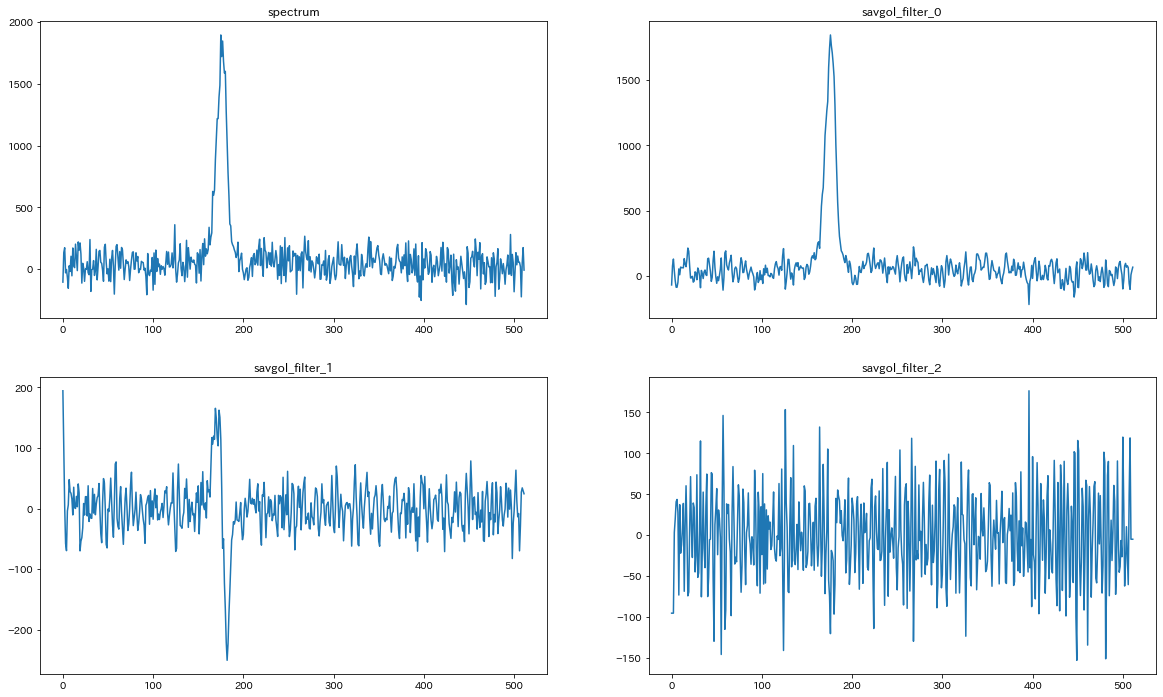

In [10]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(20, 12))
axes =  [x for a in ax for x in a]

axes[0].plot(spec_array[5][0])
axes[0].set_title('spectrum')

axes[1].plot(spec_array[5][1])
axes[1].set_title('savgol_filter_0')

axes[2].plot(spec_array[5][2])
axes[2].set_title('savgol_filter_1')

axes[3].plot(spec_array[5][3])
axes[3].set_title('savgol_filter_2')

plt.show()
# (bs, 1, 512)
# (bs, 4, 512)

In [7]:
spec_array /= spec_array.std(axis=2).reshape(-1, 4, 1)
X_seq_train = spec_array[: len(train)]
X_seq_test = spec_array[len(train) :]

In [8]:
# continuous features
data = load_features(
    all_df,
    feature_names=[
        "fitting",
        "peak_around",
        "intensity_stats",
        "savgol_peak",
        "fitting_combination",
    ],
    ignore_columns=["spectrum_id", "spectrum_filename", "chip_id"],
)
train = data[data.target.notnull()].copy()
test = data[data.target.isnull()].copy()
target_col = "target"
drop_cols = ["spectrum_id", "spectrum_filename", "chip_id"]
X_train = train.drop(drop_cols + [target_col], axis=1)
y_train = train[target_col].values
X_test = test.drop(drop_cols + [target_col], axis=1)

# fill inf/nan
X_train.replace(np.inf, np.nan, inplace=True)
X_test.replace(np.inf, np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

# https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629
prep = QuantileTransformer(output_distribution="normal")
X_cont_train = prep.fit_transform(X_train)
X_cont_test = prep.transform(X_test)

100%|██████████| 5/5 [00:00<00:00, 57.23it/s]


# Train & Predict

In [1]:
timestamp = get_timestamp()
oof_preds, test_preds, cv_scores = run(
    X_seq_train,
    X_cont_train,
    y_train,
    X_seq_test,
    X_cont_test,
    timestamp,
    random_state=0,
)